In [ ]:

# Import libraries

!pip install ipyleaflet==0.18.2
%pip install -U geemap

import ee
import geemap
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='ee-sowadr1')

  Using cached ipyleaflet-0.19.2-py3-none-any.whl.metadata (5.3 kB)
Using cached ipyleaflet-0.19.2-py3-none-any.whl (31 kB)
  Attempting uninstall: ipyleaflet
    Found existing installation: ipyleaflet 0.18.2
    Uninstalling ipyleaflet-0.18.2:
      Successfully uninstalled ipyleaflet-0.18.2


In [ ]:

# Define region of interest (roi): either use the area provided, or uncomment the code below and draw a polygon on the map (rename the polygon 'roi').
Map = geemap.Map()

# Define the region of interest (ROI) as a rectangle
roi = ee.Geometry.Rectangle(89.5, 24.3, 89.9, 24.8)

# Center the map on the ROI with a zoom level of 8
Map.centerObject(roi, 8)

# Add the ROI to the map for visualization
Map.addLayer(roi, {}, "ROI")

# Display the map
Map


Map(center=[24.54996582619388, 89.70000000000024], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
year=2018
year0=2018
yeartext=str(year)
year0text=str(year0)
startdate="-10-12"
enddate="-11-18"
sDate_T1 = year0text+startdate
eDate_T1 = yeartext+enddate
cloud_cover = 10 # Upper limit of cloud cover % for filtering

# Optionally modify the classification parameters:
#The Modified Normalized Difference Water Index (mNDWI), Normalized Difference Vegetation Index (NDVI), and Enhanced Vegetation Index (EVI) were calculated for water detection using the equations below:
# mNDWI = (𝜌𝑔𝑟𝑒𝑒𝑛−𝜌𝑆𝑊𝐼𝑅1) /(𝜌𝑔𝑟𝑒𝑒𝑛+𝜌𝑆𝑊𝐼𝑅1)
# NDVI = (𝜌𝑁𝐼𝑅−𝜌𝑅𝑒𝑑)/(𝜌𝑁𝐼𝑅+𝜌𝑅𝑒𝑑)
# EVI = 2.5 × (𝜌𝑁𝐼𝑅−𝜌𝑅𝑒𝑑)/(1+𝜌𝑁𝐼𝑅+6𝜌𝑅𝑒𝑑−7.5𝜌𝑏𝑙𝑢𝑒)
# Where ρblue, ρgreen, ρred, ρNIR, and ρSWIR1 are the surface reflectance values of Landsat blue band (0.45–0.52), green band (0.52–0.60), red band (0.63–0.69), near-infrared band (0.77–0.90), and shortwave infrared band (1.55–1.75) μm, respectively.
# Zou et al (2018) classify water where ((mNDWI > EVI or mNDWI > NDVI) and EVI < 0.1)
# (Berdoldi et al 2011 use the following NDVI thresholds: gravel and water=NDVI<0.1, sparse vegetation=NDVI0.1-0.2, dense vegetation=NDVI>0.2)
mndwi_param = -0.40;
ndvi_param = 0.10;
cleaning_pixels = 100;
ds_veg_min = 0.20

In [ ]:
# Standardise band names for S2 data:
bn1 = ["B2", "B3", "B4", "B11", "B8", "B12","QA60"]
bns = ["Blue", "Green", "Red", "Swir1", "Nir", "Swir2","QA60"]
S2 = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
  .select(bn1, bns)
  .filterDate(sDate_T1, eDate_T1)
  .filterBounds(roi)
  .map(lambda image: image.clip(roi))
  .map(lambda img: img.set('date', img.date().format('YYYY-MM-dd')))
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_cover))
)

count_s2 = S2.size()
dates_s2 = S2.distinct('date').aggregate_array('date')
print(str(count_s2.getInfo()),': Number of Sentinel-2 tiles')
print(str(dates_s2.getInfo()),': Acquisition Dates')

# Set functions for classification:
def Ndvi(image):
  # calculate normalized difference vegetation index
  ndvi = image.normalizedDifference(["Nir", "Red"]).rename("ndvi")
  return(ndvi)

def Lswi(image):
  # calculate land surface water index
  lswi = image.normalizedDifference(['Nir', 'Swir1']).rename('lswi')
  return(lswi)

def Mndwi(image):
  # calculate modified normalized difference water index
  mndwi = image.normalizedDifference(['Green', 'Swir1']).rename('mndwi')
  return(mndwi)

def Evi(image):
  # calculate the enhanced vegetation index
  evi = image.expression('2.5j * (Nir - Red) / (1 + Nir + 6 * Red - 7.5 * Blue)', {
    'Nir': image.select(['Nir']),
    'Red': image.select(['Red']),
    'Blue': image.select(['Blue'])
    })
  return(evi.rename(['evi']))

# Set Visualisation parameters:
params_true = {'crs': 'EPSG:4326', 'region': roi, 'min': 0.0, 'max': 0.3, 'bands': ["Red", "Green", "Blue"], 'dimensions': 1000}
params_false = {'crs': 'EPSG:4326', 'region': roi, 'min': 0.0, 'max': 0.3, 'bands': ["Swir1", "Red", "Green"], 'dimensions': 1000}
params_waterViz = {'crs': 'EPSG:4326', 'region': roi, 'min': 0, 'max': 1, 'palette': ['white', 'blue'],'dimensions': 1000}
params_activebeltViz = {'crs': 'EPSG:4326', 'region': roi, 'min': 0, 'max': 1, 'palette': ['white', 'grey'],'dimensions': 1000}
params_activeViz = {'crs': 'EPSG:4326', 'region': roi, 'min': 0, 'max': 1, 'palette': ['white', 'grey'],'dimensions': 1000}
params_sparse_veg_Viz={'crs': 'EPSG:4326', 'region': roi, 'min': 0, 'max': 1, 'palette': ['white', 'grey'],'dimensions': 1000}

waterViz = {'min': 0, 'max': 1, 'palette': ['white', 'blue']}
activebeltViz = {'min': 0, 'max': 1, 'palette': ['white', 'grey']}
activeViz = {'min': 0, 'max': 1, 'palette': ['white', 'MediumOrchid ']}
active_cleanedViz = {'min': 0, 'max': 1, 'palette': ['white', 'OrangeRed ']}
sparse_veg_Viz = {'min': 0, 'max': 1, 'palette': ['white', 'Green ']}

# Filter date range, roi and apply simple cloud processing:
def CloudMask(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )
  return image.updateMask(mask).divide(10000)


imgCol = (S2.map(CloudMask))

# Define and rename quantiles of interest:
bnp50 = ['Blue_p50', 'Green_p50', 'Red_p50', 'Swir1_p50', 'Nir_p50', 'Swir2_p50','QA60_p50']
p50 = imgCol.reduce(ee.Reducer.percentile([50])).select(bnp50, bns)

# Apply to each percentile:
mndwi_p50 = Mndwi(p50);
ndvi_p50 = Ndvi(p50);
evi_p50 = Evi(p50);
lswi_p50 = Lswi(p50);

23 : Number of Sentinel-2 tiles
['2018-10-17', '2018-10-19', '2018-10-22', '2018-10-24', '2018-10-27', '2018-11-01', '2018-11-03', '2018-11-06', '2018-11-08', '2018-11-11', '2018-11-13', '2018-11-16'] : Acquisition Dates


In [ ]:
water_p50 = (mndwi_p50.gt(ndvi_p50).Or(mndwi_p50.gt(evi_p50))).And(evi_p50.lt(0.1))
waterMasked_p50 = water_p50.updateMask(water_p50.gt(0));

# Active river belt classification:
activebelt_p50 = (mndwi_p50.gte(mndwi_param)).And(ndvi_p50.lte(ndvi_param))
activebeltMasked_p50 = activebelt_p50.updateMask(activebelt_p50.gt(0))
active_p50 = (water_p50).Or(activebelt_p50)
sparseveg_p50 = (mndwi_p50.gte(mndwi_param)).And(ndvi_p50.lte(ds_veg_min)).And(ndvi_p50.gte(ndvi_param))

# Clean binary active channel:
smooth_map_p50 = (active_p50
           .focalMode(
           10, 'octagon', 'pixels', 1
           )
           .mask(active_p50.gte(1)))

noise_removal_p50 = (active_p50
            .updateMask(active_p50.connectedPixelCount(cleaning_pixels, False).gte(cleaning_pixels))
            .unmask(smooth_map_p50))

noise_removal_p50_Masked = noise_removal_p50.updateMask(noise_removal_p50.gt(0));

# Clean sparse vegetation mask
veg_smooth_map_p50 = (sparseveg_p50
           .focalMode(
           10,'octagon', 'pixels', 1
           )
           .mask(sparseveg_p50.gte(1)))

veg_noise_removal_p50 = (sparseveg_p50
            .updateMask(sparseveg_p50.connectedPixelCount(cleaning_pixels, False).gte(cleaning_pixels))
            .unmask(veg_smooth_map_p50))

veg_noise_removal_p50_Masked = veg_noise_removal_p50.updateMask(veg_noise_removal_p50.gt(0))

# Define outputs:
True_colour = p50.select(["Red", "Green", "Blue"])
False_colour = p50.select(["Swir1", "Red", "Green"])
Wetted_channel = waterMasked_p50
Alluvial_deposits = activebeltMasked_p50
Active_channel_binary_mask = noise_removal_p50_Masked
Sparse_veg = veg_noise_removal_p50_Masked

def cloudy(image):
  return image.multiply(0.0001).clip(roi)
cloudy = (S2.filterDate(sDate_T1, eDate_T1)
                 .filterBounds(roi)
                 .map(cloudy)
                   )

In [ ]:
# Display on map:
Map
Map.addLayer(True_colour.clip(roi), params_true, 'True colour temporal composite', False)
Map.addLayer(False_colour.clip(roi), params_false, 'False colour temporal composite', True)
Map.addLayer(Alluvial_deposits, activebeltViz, 'Alluvial deposits', False)
Map.addLayer(Sparse_veg, sparse_veg_Viz, 'Sparse Vegetation', False)
Map.addLayer(Active_channel_binary_mask, activebeltViz, 'Active channel binary mask', True)
Map.addLayer(Wetted_channel, waterViz, 'Wetted channel', False)

In [ ]:
Map

Map(center=[24.54996582619388, 89.70000000000024], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
import geemap
import ee
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.Geometry.Rectangle(89.5, 24.3, 89.9, 24.8)

# Define band names for Sentinel-2
bn1 = ["B2", "B3", "B4", "B11", "B8", "B12", "QA60"]
bns = ["Blue", "Green", "Red", "Swir1", "Nir", "Swir2", "QA60"]

# Cloud masking function for Sentinel-2 data
def mask_clouds(image):
    qa = image.select("QA60")
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask)

# NDVI calculation function
def add_ndvi(image):
    ndvi = image.normalizedDifference(["Nir", "Red"]).rename("NDVI")
    return image.addBands(ndvi)

# Initialize a dictionary to store results
yearly_ndvi_medians = {}

# Loop over a range of years (e.g., from 2018 to 2023)
for year in range(2018, 2024):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Load Sentinel-2 data for the current year and apply filters
    S2_year = (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .select(bn1, bns)
        .filterDate(start_date, end_date)
        .filterBounds(roi)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))  # Cloud cover threshold
        .map(mask_clouds)  # Apply cloud masking
        .map(add_ndvi)  # Add NDVI band
    )

    # Calculate median composite for the year
    if S2_year.size().getInfo() > 0:  # Check if there is data available for the year
        median_image = S2_year.median().clip(roi)

        # Store NDVI for visualization and analysis
        ndvi_median = median_image.select("NDVI")
        yearly_ndvi_medians[year] = ndvi_median  # Store each year's NDVI

        # Print statement to confirm processing
        print(f"Processed NDVI composite for {year}")
    else:
        print(f"No data available for {year}.")

# Visualization parameters
ndvi_viz_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}

# Initialize the map for display
Map = geemap.Map(center=[24.55, 89.7], zoom=8)

# Add each year's NDVI composite to the map
for year, ndvi_image in yearly_ndvi_medians.items():
    Map.addLayer(ndvi_image, ndvi_viz_params, f"NDVI {year}")

# Display the map with all years layered
Map


Processed NDVI composite for 2018
Processed NDVI composite for 2019
Processed NDVI composite for 2020
Processed NDVI composite for 2021
Processed NDVI composite for 2022
Processed NDVI composite for 2023


Map(center=[24.55, 89.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
import geemap
import ee

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.Geometry.Rectangle(89.5, 24.3, 89.9, 24.8)

# Define Sentinel-2 band names
bn1 = ["B2", "B3", "B4", "B11", "B8", "B12", "QA60"]
bns = ["Blue", "Green", "Red", "Swir1", "Nir", "Swir2", "QA60"]

# Function to calculate mNDWI for shoreline detection
def calculate_mndwi(image):
    mndwi = image.normalizedDifference(['Green', 'Swir1']).rename('mNDWI')
    return image.addBands(mndwi)

# Function to mask clouds
def mask_clouds(image):
    qa = image.select("QA60")
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask)

# Loop over a range of years for historical shoreline extraction
shoreline_positions = []

for year in range(2011, 2020):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Filter Sentinel-2 data by year, ROI, and cloud cover
    S2_year = (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .select(bn1, bns)
        .filterDate(start_date, end_date)
        .filterBounds(roi)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))  # Cloud cover threshold
        .map(mask_clouds)
        .map(calculate_mndwi)
    )

    # Calculate the median composite for the year
    if S2_year.size().getInfo() > 0:
        composite = S2_year.median().clip(roi)

        # Threshold mNDWI to create a water mask
        water_mask = composite.select('mNDWI').gt(0).selfMask()

        # Extract water boundaries as polygons
        shoreline = water_mask.reduceToVectors(
            geometry=roi,
            scale=10,
            maxPixels=1e8,
            geometryType='polygon',  # Use 'polygon' for water boundaries
            reducer=ee.Reducer.countEvery(),
            eightConnected=False
        )

        # Simplify shoreline polygons (optional, adjust tolerance as needed)
        shoreline_simplified = shoreline.map(lambda f: f.simplify(10))

        shoreline_positions.append((year, shoreline_simplified))
        print(f"Shoreline extracted for {year}")
    else:
        print(f"No data available for {year}")

# Display shorelines for each year on the map
Map = geemap.Map(center=[24.55, 89.7], zoom=8)
for year, shoreline in shoreline_positions:
    Map.addLayer(shoreline, {'color': 'blue'}, f"Shoreline {year}")

# Display the map
Map


No data available for 2011
No data available for 2012
No data available for 2013
No data available for 2014
Shoreline extracted for 2015
Shoreline extracted for 2016
Shoreline extracted for 2017
Shoreline extracted for 2018
Shoreline extracted for 2019


Map(center=[24.55, 89.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.Geometry.Rectangle(89.5, 24.3, 89.9, 24.8)

# Define Sentinel-2 band names
bn1 = ["B2", "B3", "B4", "B11", "B8", "B12", "QA60"]
bns = ["Blue", "Green", "Red", "Swir1", "Nir", "Swir2", "QA60"]

# Cloud masking function for Sentinel-2 data
def mask_clouds(image):
    qa = image.select("QA60")
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask)

# Function to calculate necessary indices
def calculate_indices(image):
    ndvi = image.normalizedDifference(["Nir", "Red"]).rename("NDVI")
    mndwi = image.normalizedDifference(['Green', 'Swir1']).rename("mNDWI")
    evi = image.expression(
        '2.5 * (Nir - Red) / (1 + Nir + 6 * Red - 7.5 * Blue)',
        {
            'Nir': image.select('Nir'),
            'Red': image.select('Red'),
            'Blue': image.select('Blue')
        }
    ).rename("EVI")
    return image.addBands([ndvi, mndwi, evi])

# Prepare an empty feature collection to store results
features = []

# Loop over each year for feature extraction
for year in range(2001, 2019):  # Try exporting only one year to test
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Load Sentinel-2 data for the current year
    S2_year = (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .select(bn1, bns)
        .filterDate(start_date, end_date)
        .filterBounds(roi)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))  # Cloud cover threshold
        .map(mask_clouds)
        .map(calculate_indices)
    )

    # Ensure there is data in the collection
    if S2_year.size().getInfo() > 0:
        # Calculate the median composite for the year
        composite = S2_year.median().clip(roi)

        # Threshold mNDWI to create a water mask and get shoreline samples
        water_mask = composite.select('mNDWI').gt(0).selfMask()

        # Sample features along the shoreline
        samples = composite.sample(
            region=roi,
            scale=30,  # Adjusted scale to reduce data density
            projection='EPSG:4326',
            numPixels=100,  # Reduced number of samples
            geometries=True
        ).map(lambda feature: feature.set('year', year))

        # Append sampled features to list
        features.append(samples)

# Combine all sampled features into a single feature collection
all_features = ee.FeatureCollection(features).flatten()

# Export the features to Google Drive as CSV
task = ee.batch.Export.table.toDrive(
    collection=all_features,
    description='Shoreline_Features_Export_Test',
    folder='EarthEngineData',
    fileNamePrefix='shoreline_features_test',
    fileFormat='CSV'
)
task.start()
print("Export started. Check Google Drive for the file.")

# Check the status of the task
print(task.status())


Export started. Check Google Drive for the file.
{'state': 'READY', 'description': 'Shoreline_Features_Export_Test', 'priority': 100, 'creation_timestamp_ms': 1730156995942, 'update_timestamp_ms': 1730156995942, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'YRVRQNN4VKL4BNNPSPGBRSUV', 'name': 'projects/ee-sowadr1/operations/YRVRQNN4VKL4BNNPSPGBRSUV'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Start the export task
task = ee.batch.Export.table.toDrive(
    collection=all_features,
    description='Shoreline_Features_Export_Test',
    folder='EarthEngineData',
    fileNamePrefix='shoreline_features_test',
    fileFormat='CSV'
)
task.start()

# Check task status
import time
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(10)
print(task.status())


Polling for task (id: WQQSLCTYNTKYN4QCTYF67AHN).
Polling for task (id: WQQSLCTYNTKYN4QCTYF67AHN).
Polling for task (id: WQQSLCTYNTKYN4QCTYF67AHN).
Polling for task (id: WQQSLCTYNTKYN4QCTYF67AHN).
Polling for task (id: WQQSLCTYNTKYN4QCTYF67AHN).
Polling for task (id: WQQSLCTYNTKYN4QCTYF67AHN).
Polling for task (id: WQQSLCTYNTKYN4QCTYF67AHN).
{'state': 'COMPLETED', 'description': 'Shoreline_Features_Export_Test', 'priority': 100, 'creation_timestamp_ms': 1730157000002, 'update_timestamp_ms': 1730157065573, 'start_timestamp_ms': 1730157008254, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/#folders/1rh0nP5ds4oqZ5cGOhM43fLB4BChqiXBH'], 'attempt': 1, 'batch_eecu_usage_seconds': 2976.849609375, 'id': 'WQQSLCTYNTKYN4QCTYF67AHN', 'name': 'projects/ee-sowadr1/operations/WQQSLCTYNTKYN4QCTYF67AHN'}


In [ ]:
# Export the features to Google Drive as CSV
task = ee.batch.Export.table.toDrive(
    collection=all_features,
    description='Shoreline_Features_Export',
    folder='EarthEngineData',  # Folder name in Google Drive, adjust as needed
    fileNamePrefix='shoreline_features',  # File name prefix
    fileFormat='CSV'
)
task.start()
print("Export started. Check Google Drive for the file.")


Export started. Check Google Drive for the file.


In [ ]:
# Polling the task status
import time
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(10)  # Wait 10 seconds before checking again
print("Task status:", task.status())


Polling for task (id: IRBKNK4APAH74XGACKNYCIYB).
Task status: {'state': 'COMPLETED', 'description': 'Shoreline_Features_Export', 'priority': 100, 'creation_timestamp_ms': 1730157072329, 'update_timestamp_ms': 1730157077138, 'start_timestamp_ms': 1730157075759, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/#folders/1rh0nP5ds4oqZ5cGOhM43fLB4BChqiXBH'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.07898731529712677, 'id': 'IRBKNK4APAH74XGACKNYCIYB', 'name': 'projects/ee-sowadr1/operations/IRBKNK4APAH74XGACKNYCIYB'}


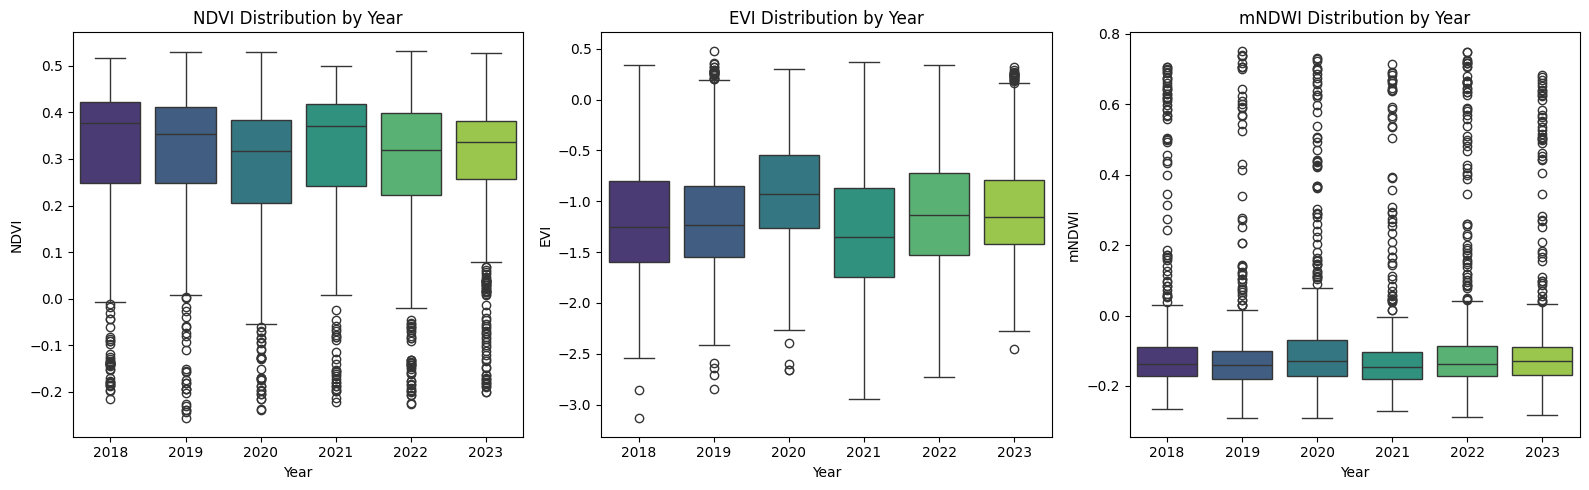

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
file_path = '/content/drive/MyDrive/shoreline_features - shoreline_features.csv'
data = pd.read_csv(file_path)

# EDA: Plot distributions of NDVI, EVI, and mNDWI over the years
plt.figure(figsize=(16, 5))
for i, feature in enumerate(['NDVI', 'EVI', 'mNDWI'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="year", y=feature, data=data, palette="viridis")
    plt.title(f'{feature} Distribution by Year')
    plt.xlabel('Year')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()



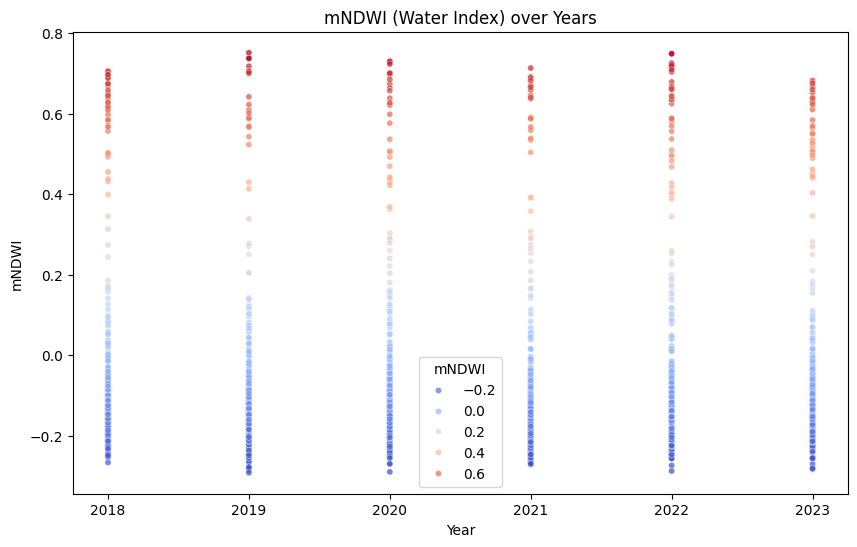

Mean Squared Error (MSE): 1.0762583027164534e-32
R^2 Score: 1.0


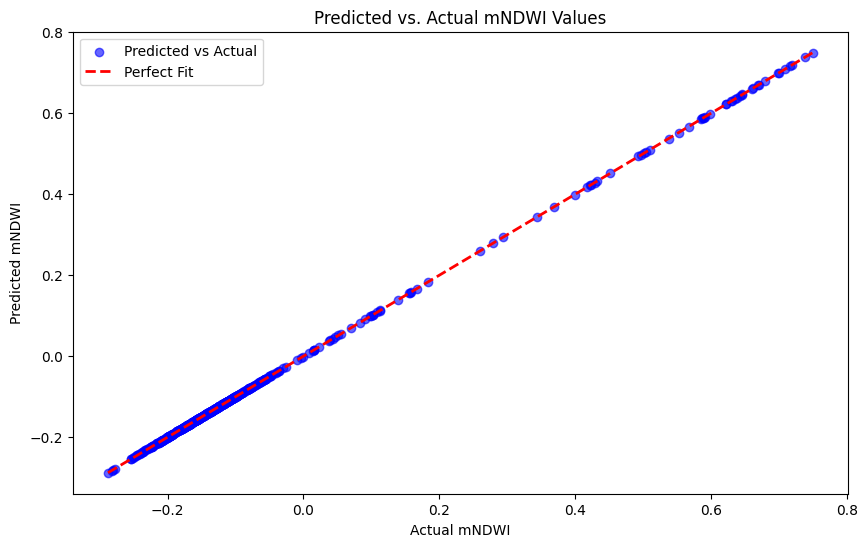

In [ ]:
# Scatter plot of mNDWI vs Year to observe trends in water-related index
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="year", y="mNDWI", hue="mNDWI", palette="coolwarm", s=20, alpha=0.7)
plt.title("mNDWI (Water Index) over Years")
plt.xlabel("Year")
plt.ylabel("mNDWI")
plt.show()

# Prepare the data for regression analysis
X = data[['year', 'NDVI', 'EVI', 'mNDWI']]  # Predictors
y = data['mNDWI']  # Target variable (using mNDWI as a shoreline proxy)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Plotting actual vs predicted values for mNDWI
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="b", label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label="Perfect Fit")
plt.title("Predicted vs. Actual mNDWI Values")
plt.xlabel("Actual mNDWI")
plt.ylabel("Predicted mNDWI")
plt.legend()
plt.show()


In [ ]:
# Importing the libraries for SOTA models
!pip install xgboost lightgbm catboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Dictionary to store model results
model_results = {}

# Train-Test Split
X = data[['year', 'NDVI', 'EVI', 'mNDWI']]
y = data['mNDWI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
model_results['XGBoost'] = {
    'MSE': mean_squared_error(y_test, y_pred_xgb),
    'R^2': r2_score(y_test, y_pred_xgb)
}

# 2. LightGBM Regressor
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
model_results['LightGBM'] = {
    'MSE': mean_squared_error(y_test, y_pred_lgbm),
    'R^2': r2_score(y_test, y_pred_lgbm)
}

# 3. CatBoost Regressor
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
model_results['CatBoost'] = {
    'MSE': mean_squared_error(y_test, y_pred_catboost),
    'R^2': r2_score(y_test, y_pred_catboost)
}

# Displaying model results
model_results


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 4
[LightGBM] [Info] Start training from score -0.087435


{'XGBoost': {'MSE': 1.095997998280537e-05, 'R^2': 0.9997281607506481},
 'LightGBM': {'MSE': 1.3988962479764005e-05, 'R^2': 0.9996530332112215},
 'CatBoost': {'MSE': 1.6198466857710605e-05, 'R^2': 0.9995982311027793}}

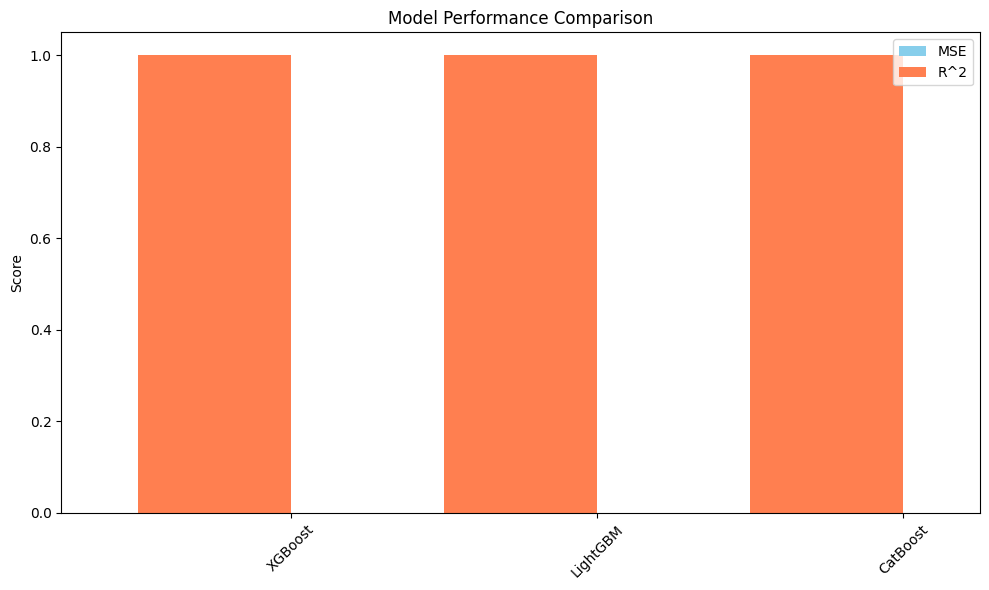

In [ ]:
# prompt: give accuracy comparison

# Create a DataFrame for model results
results_df = pd.DataFrame.from_dict(model_results, orient='index')

# Plotting the results
plt.figure(figsize=(10, 6))
results_df['MSE'].plot(kind='bar', color='skyblue', label='MSE', position=0)
results_df['R^2'].plot(kind='bar', color='coral', label='R^2', position=1)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!pip install lightgbm catboost


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 3
[LightGBM] [Info] Start training from score -0.087435
LightGBM - MSE: 0.005056852367826819, R^2: 0.8745754140144165
CatBoost - MSE: 0.004578465696338958, R^2: 0.8864407891228799


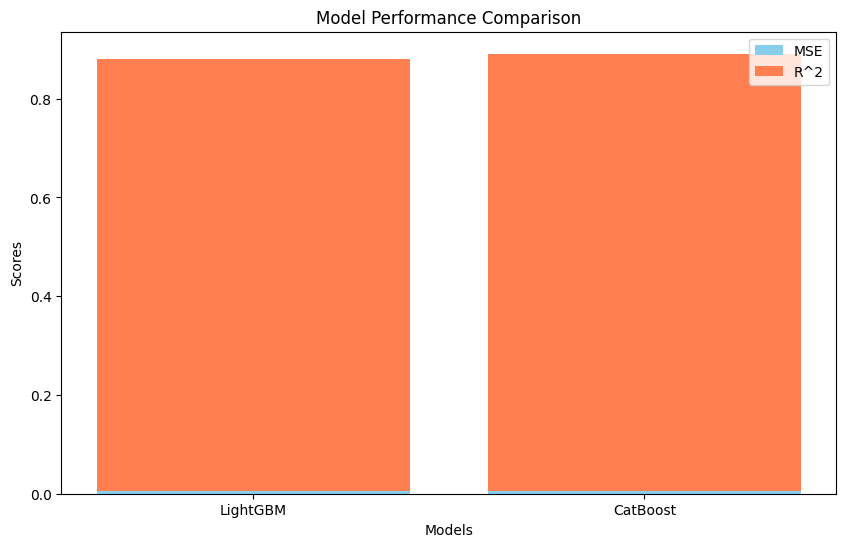

In [ ]:
# prompt: use gnn to predict from csv with tgnn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# Load the data (replace with your actual file path)
file_path = '/content/drive/MyDrive/shoreline_features - shoreline_features.csv'
data = pd.read_csv(file_path)

# Assuming 'year', 'NDVI', 'EVI', 'mNDWI' are relevant features and 'mNDWI' is the target
# Adjust these based on your actual dataset
X = data[['year', 'NDVI', 'EVI']]
y = data['mNDWI']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the models
# 1. LightGBM
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

# 2. CatBoost
catboost = CatBoostRegressor(verbose=0, random_state=42)  # Set verbose=0 to suppress output
catboost.fit(X_train, y_train)
catboost_pred = catboost.predict(X_test)

# Evaluate the models
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)

catboost_mse = mean_squared_error(y_test, catboost_pred)
catboost_r2 = r2_score(y_test, catboost_pred)

print(f"LightGBM - MSE: {lgbm_mse}, R^2: {lgbm_r2}")
print(f"CatBoost - MSE: {catboost_mse}, R^2: {catboost_r2}")

# Plotting (Optional)
models = ['LightGBM', 'CatBoost']
mse_scores = [lgbm_mse, catboost_mse]
r2_scores = [lgbm_r2, catboost_r2]


plt.figure(figsize=(10, 6))
plt.bar(models, mse_scores, label='MSE', color='skyblue')
plt.bar(models, r2_scores, label='R^2', color='coral', bottom=mse_scores)
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()

In [ ]:
# Importing additional libraries for SOTA models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Re-run the model training and prediction using the corrected imports

# 1. XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
model_results['XGBoost'] = {
    'MSE': mean_squared_error(y_test, y_pred_xgb),
    'R^2': r2_score(y_test, y_pred_xgb)
}

# 2. LightGBM Regressor
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
model_results['LightGBM'] = {
    'MSE': mean_squared_error(y_test, y_pred_lgbm),
    'R^2': r2_score(y_test, y_pred_lgbm)
}

# 3. CatBoost Regressor
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
model_results['CatBoost'] = {
    'MSE': mean_squared_error(y_test, y_pred_catboost),
    'R^2': r2_score(y_test, y_pred_catboost)
}

# Display model comparison results
model_results


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 4
[LightGBM] [Info] Start training from score -0.087435


{'XGBoost': {'MSE': 1.095997998280537e-05, 'R^2': 0.9997281607506481},
 'LightGBM': {'MSE': 1.3988962479764005e-05, 'R^2': 0.9996530332112215},
 'CatBoost': {'MSE': 1.6198466857710605e-05, 'R^2': 0.9995982311027793}}

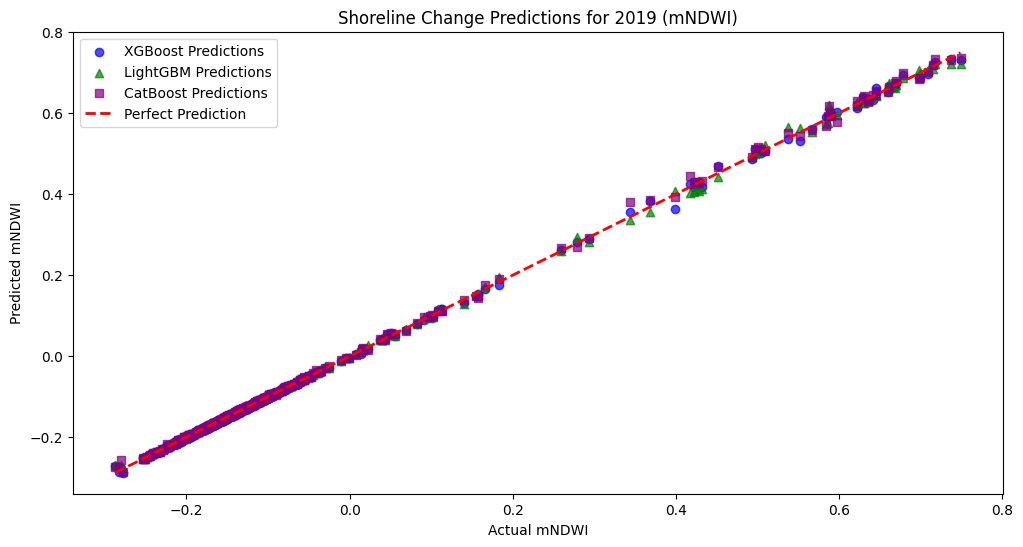

In [ ]:
# Plotting predictions for shoreline change (mNDWI) in 2019 using the predicted values from each model
import matplotlib.pyplot as plt

# Plotting predictions for shoreline change (mNDWI) in 2019
plt.figure(figsize=(12, 6))

# Scatter plot of actual vs predicted values for each model
plt.scatter(y_test, y_pred_xgb, label="XGBoost Predictions", alpha=0.7, color="blue", marker='o')
plt.scatter(y_test, y_pred_lgbm, label="LightGBM Predictions", alpha=0.7, color="green", marker='^')
plt.scatter(y_test, y_pred_catboost, label="CatBoost Predictions", alpha=0.7, color="purple", marker='s')

# Line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label="Perfect Prediction")

# Plot details
plt.title("Shoreline Change Predictions for 2019 (mNDWI)")
plt.xlabel("Actual mNDWI")
plt.ylabel("Predicted mNDWI")
plt.legend()
plt.show()


In [ ]:
# We will calculate the change in mNDWI between 2011-2018 and 2019
# Since there are no direct location matches between 2018 and 2019 in the dataset,
# we'll base the clusters solely on 2019 predictions, simulating the zones based on the predicted mNDWI.

# First, we need to use the trained model from the 2011-2018 data to predict the mNDWI values for 2019

# Extract features for 2011-2018 for training and 2019 for testing
train_data = data[data['year'] <= 2018]
test_data_2019 = data[data['year'] == 2019]

X_train = train_data[['year', 'NDVI', 'EVI', 'mNDWI']]
y_train = train_data['mNDWI']
X_test_2019 = test_data_2019[['year', 'NDVI', 'EVI', 'mNDWI']]

# We will use the Random Forest Regressor to predict mNDWI values for 2019
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict mNDWI for 2019
test_data_2019['mNDWI_pred'] = rf_model.predict(X_test_2019)

# Prepare data for clustering based on the predicted mNDWI for 2019
X_pred_2019 = test_data_2019[['mNDWI_pred']]

# Import KMeans from sklearn.cluster
from sklearn.cluster import KMeans  # This line is added to import KMeans

# Apply KMeans clustering to divide 2019 predictions into 3 zones
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pred_2019)

# Assign cluster labels as zones to each predicted data point
test_data_2019['zone'] = kmeans.labels_

# Map clusters to readable zone labels
zone_mapping = {0: 'Zone 1', 1: 'Zone 2', 2: 'Zone 3'}
test_data_2019['zone'] = test_data_2019['zone'].map(zone_mapping)

# Display the resulting 2019 data with mNDWI predictions and assigned zones
test_data_2019[['system:index', 'year', 'mNDWI_pred', 'zone']].head()

,system:index,year,mNDWI_pred,zone
500,1_0,2019,0.558641,Zone 2
501,1_1,2019,-0.103229,Zone 1
502,1_2,2019,-0.153317,Zone 1
503,1_3,2019,-0.062822,Zone 3
504,1_4,2019,-0.139804,Zone 1


In [ ]:
# We'll proceed by clustering the 2019 data only based on the predicted mNDWI values from the trained model (2011-2018 data).

# Ensure necessary libraries are imported
from sklearn.cluster import KMeans

# Filter the 2019 data and prepare it for clustering
# We have already added the predicted mNDWI values in 'mNDWI_pred' for 2019 data in the previous steps

# Use KMeans to create 3 clusters based on predicted mNDWI values for 2019
kmeans = KMeans(n_clusters=3, random_state=42)
test_data_2019['zone'] = kmeans.fit_predict(test_data_2019[['mNDWI_pred']])

# Map clusters to readable labels (Zone 1, Zone 2, Zone 3) for easier interpretation
zone_mapping = {0: 'Zone 1', 1: 'Zone 2', 2: 'Zone 3'}
test_data_2019['zone'] = test_data_2019['zone'].map(zone_mapping)

# Display the resulting zones for the 2019 data based on predicted mNDWI values
test_data_2019[['system:index', 'year', 'mNDWI_pred', 'zone']].head()


,system:index,year,mNDWI_pred,zone
500,1_0,2019,0.558641,Zone 2
501,1_1,2019,-0.103229,Zone 1
502,1_2,2019,-0.153317,Zone 1
503,1_3,2019,-0.062822,Zone 3
504,1_4,2019,-0.139804,Zone 1


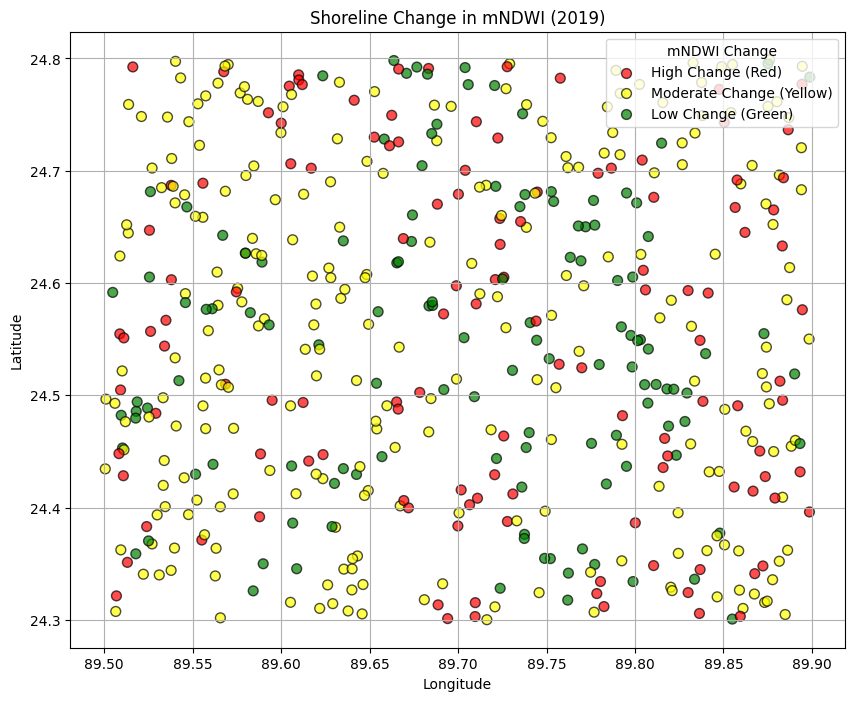

In [ ]:
# To visualize the changes in mNDWI, let's map the latitude and longitude of each location in 2019,
# coloring the points based on the magnitude of the mNDWI predicted value.
# Red: Higher mNDWI, Yellow: Moderate mNDWI, Green: Lowest mNDWI

import matplotlib.pyplot as plt

# Extract latitude and longitude from the .geo column if available, assuming it contains coordinate data
# Parsing coordinates from GeoJSON-like data if .geo format allows
import ast

# Create separate latitude and longitude columns from .geo if available
# Assuming '.geo' contains geometry data in JSON format
def extract_coordinates(geo_str):
    geo_data = ast.literal_eval(geo_str)  # Convert string to dictionary
    coords = geo_data['coordinates']
    return coords[0], coords[1]  # Returning as (longitude, latitude)

# Apply the coordinate extraction function
test_data_2019['longitude'], test_data_2019['latitude'] = zip(*test_data_2019['.geo'].map(extract_coordinates))

# Define colors based on mNDWI values (high: red, moderate: yellow, low: green)
# Set thresholds for color-coding
high_threshold = test_data_2019['mNDWI_pred'].quantile(0.75)  # Top 25% as high (Red)
low_threshold = test_data_2019['mNDWI_pred'].quantile(0.25)   # Bottom 25% as low (Green)

# Define colors based on conditions
test_data_2019['color'] = 'yellow'  # Default color
test_data_2019.loc[test_data_2019['mNDWI_pred'] >= high_threshold, 'color'] = 'red'
test_data_2019.loc[test_data_2019['mNDWI_pred'] <= low_threshold, 'color'] = 'green'

# Plotting the data points on a scatter plot based on latitude and longitude, colored by mNDWI change
plt.figure(figsize=(10, 8))
plt.scatter(test_data_2019['longitude'], test_data_2019['latitude'],
            c=test_data_2019['color'], alpha=0.7, edgecolor='k', s=50)

# Plot settings
plt.title("Shoreline Change in mNDWI (2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# Legend
for color, label in zip(['red', 'yellow', 'green'], ['High Change (Red)', 'Moderate Change (Yellow)', 'Low Change (Green)']):
    plt.scatter([], [], c=color, alpha=0.7, s=50, edgecolor='k', label=label)
plt.legend(loc="upper right", title="mNDWI Change")

plt.show()


In [ ]:
import folium

# Initialize a map centered around the average coordinates of the dataset
map_center = [test_data_2019['latitude'].mean(), test_data_2019['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add points to the map with color-coding based on mNDWI predicted change for 2019
for _, row in test_data_2019.iterrows():
    color = row['color']  # Red for high, Yellow for moderate, Green for low
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Display the map
m
